## Tutorial: how to import the data and visualise them

In [7]:
import numpy as np
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
#from tree import FamilyTree
from data_handler import ParticleDataset

import ot
import graphicle as gcl

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch

#helper functions for plots
from utils.visualisation import plot_geodesic, get_colors, hard_descendants
from utils.metrics import sqdist, distance_matrix, precision_and_recall, mAP

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

## The dataset

The dataset is structured as a Pytorch dataset. The two inputs are the path for the data directory and the signal name (this depends on the physics event we are interested in and it is chosen once the data is generated).

The dataset spits each event as dictionary which contains a graphicle object and a hyperbolic coordinates array for each of the algorithm tree (AntiKt, CA and Kt) and for the MC truth.

In [84]:
dataset = ParticleDataset('data/compare_algo/')
event = dataset[4]

In [85]:
event.keys()

dict_keys(['MC_graph', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp'])

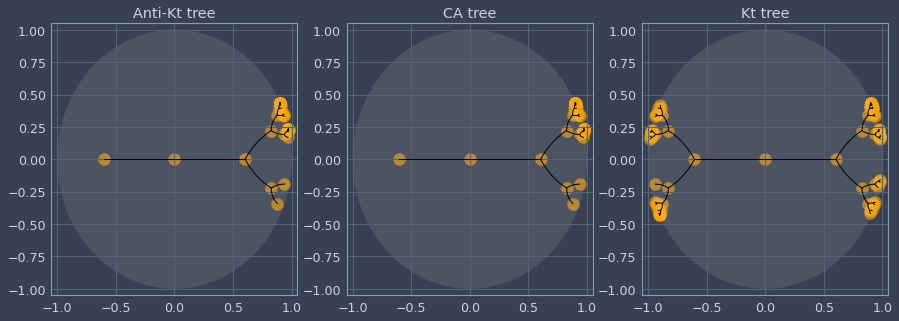

In [86]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()

keys = [k for k in event.keys()]
titles = ['Anti-Kt tree', 'CA tree', 'Kt tree',]
for k in range(1, 6, 2):
    i = k//2
    graph, hyp = event[keys[k]], event[keys[k+1]]
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    G = nx.Graph()
    G.add_edges_from(graph.edges)
    nodes = np.array(G.nodes())
    mapping = {nodes[i]: i for i in range(len(nodes))}
    G = nx.relabel_nodes(G, mapping)
    nodes = np.array(G.nodes())
    for edge in G.edges:
        start = np.where(nodes == edge[0])[0][0]
        end = np.where(nodes == edge[1])[0][0]
        x0,y0 = hyp[start]
        x1,y1 = hyp[end]
        #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
        plot_geodesic(hyp[start],hyp[end],ax[i])

    ax[i].scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax[i].add_patch(disk)
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(-1.05,1.05)
    ax[i].set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## Distance matrices analysis

## Local graph metric - mean average precision (mAP)

## Testing Sarkar algorithm

In [13]:
#dataset = ParticleDataset('data/test', 'signal')
#event = dataset[15]

dataset = ParticleDataset('data/higgs_tagging/signal', 'signal')
event = dataset[1]
graph = event['MC_graph']

tree = FamilyTree(graph)
g = tree.history(p=0)


In [62]:
from hyperlib.embedding.sarkar import sarkar_embedding

#G = nx.balanced_tree(2,5)
#graph = event['Kt_graph']
G = nx.Graph()
#G.add_edges_from(akt.edges[1:])
G.add_edges_from(graph.edges)
nodes = np.array(G.nodes())
mapping = {nodes[i]: i for i in range(len(nodes))}
G = nx.relabel_nodes(G, mapping)
#G = nx.balanced_tree(3,4)
embed = sarkar_embedding(tree=G, root=mapping[-1], tau=0.7, weighted=False)#, tau=tau)
#plot_embedding(T, emb, labels=labels)
hyp = np.array(list(map(float, embed))).reshape(-1,2)

In [63]:
distances = distance_matrix(hyp, off_diag=False)
mAP = 0
nodes = np.array(list(G.nodes()))
for node_idx in range(len(nodes)):
    node = nodes[node_idx]
    # get the neighbours of a node
    neighbours = list(G.neighbors(node))
    temp_mAP = 0
    for neigh in neighbours:
        # define the circle's radius
        neigh_idx = np.where(nodes == neigh)[0]
        radius = distances[node_idx][neigh_idx][0]

        # find all the nodes within the circle
        radius_mask = distances[node_idx] <= radius
        # remove self loop
        radius_mask[node_idx] = False

        nodes_in_circle = nodes[radius_mask]
        # count how manyy should be there
        num = len(set(nodes_in_circle).intersection(set(neighbours)))
        den = len(nodes_in_circle)

        temp_mAP  += num / den

    mAP += temp_mAP / len(neighbours)

mAP /= G.number_of_nodes()
mAP

1.0

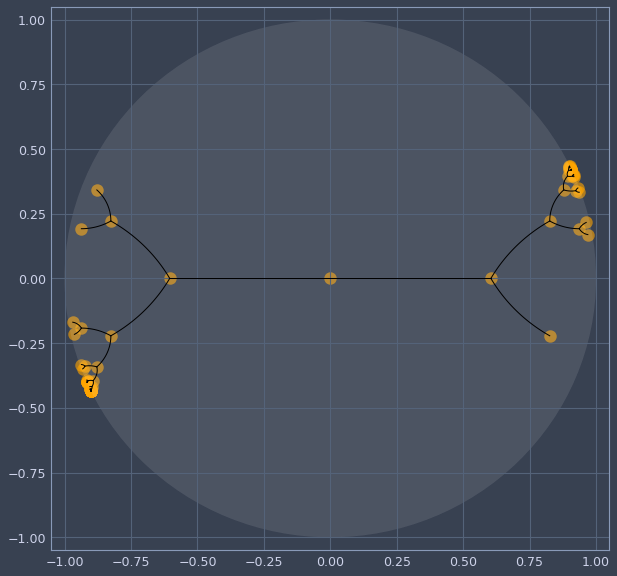

In [59]:
fig,ax = plt.subplots(figsize=(10,10))

nodes = np.array(G.nodes())
for edge in G.edges:
    start = np.where(nodes == edge[0])[0][0]
    end = np.where(nodes == edge[1])[0][0]
    x0,y0 = hyp[start]
    x1,y1 = hyp[end]
    #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
    plot_geodesic(hyp[start],hyp[end],ax)

'''
graph = event['MC_graph']
mask = graph.final.data
hard_mask = hard_descendants(graph, 25)
hard_mask = hard_mask[mask]

graph = event['Kt_graph']
mask = graph.final.data
ax.scatter(hyp[:,0][mask], hyp[:,1][mask], 
    c='orange', s=150, alpha=0.6)
#ax.scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
#    facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)

#ax.scatter(hyp[:,0][mask][hard_mask], hyp[:,1][mask][hard_mask], 
#    c='#DB2065', s=150, alpha=0.6)    
'''
    
    
ax.scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
  
disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
ax.add_patch(disk)
ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
#ax.set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## EMD study 

In this section we analyse the EMD between different algorithm for the same jet.

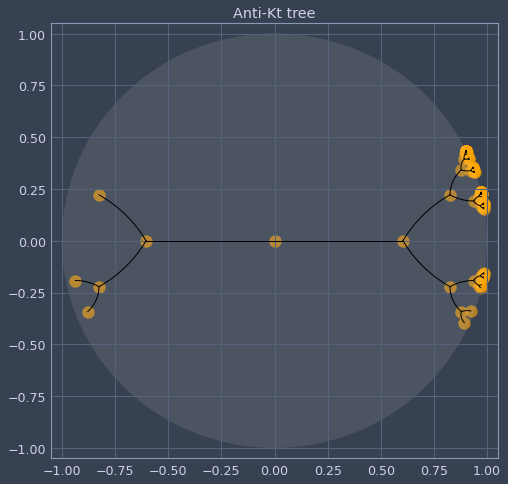

In [2]:
dataset = ParticleDataset('data/compare_algo/')
data = dataset[0]

In [3]:
keys = [k for k in data.keys()]

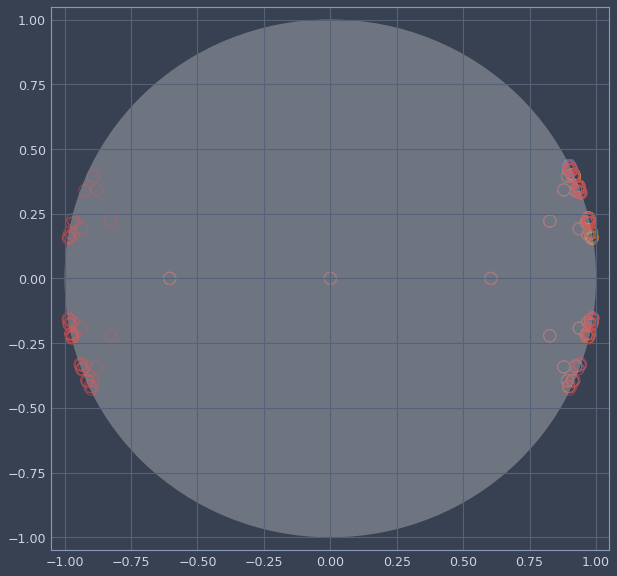

In [4]:
fig,ax = plt.subplots(figsize=(10,10))

color = ['orange','b','r']
for k in range(1, 6, 2):
    i = k//2
    graph, hyp = data[keys[k]], data[keys[k+1]]
    mask = graph.final
    ax.scatter(hyp[:,0], hyp[:,1], s=150, facecolor='none', edgecolor=color[i],
               linewidth=1,alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax.add_patch(disk)
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

plt.show()
#plt.savefig('example.png')

In [5]:
g1, h1 = data[keys[1]], data[keys[2]]
g2, h2 = data[keys[3]], data[keys[4]]
mask1 = g1.final
mask2 = g2.final
e1 = g1.pmu.data['e'][mask1]
e2 = g2.pmu.data['e'][mask2]

In [43]:
g = data[keys[0]]
pyjet_dtype = {'names': ('E', 'px', 'py', 'pz'),
               'formats': ('f8', 'f8', 'f8', 'f8')}

mask = g.final.data
event = g.pmu.data[mask][['e', 'x', 'y', 'z']].copy().astype(pyjet_dtype)
event = append_fields(event, 'id', data=np.arange(len(event)))

s1 = cluster(event, R=0.8, p=-1, ep=True)
s2 = cluster(event, R=0.8, p=-1, ep=True)

j1 = s1.inclusive_jets()
j2 = s2.inclusive_jets()

NameError: name 'append_fields' is not defined

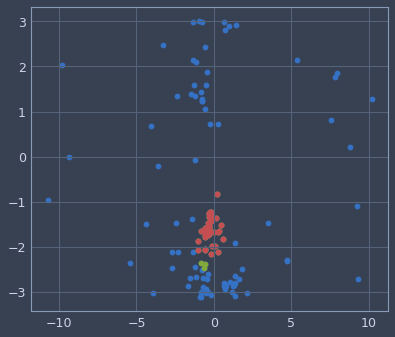

In [121]:
fig, ax = plt.subplots()
ax.scatter(g.pmu.eta[mask], g.pmu.phi[mask])
ax.scatter(g1.pmu.eta[g1.final], g1.pmu.phi[g1.final])
ax.scatter(g2.pmu.eta[g2.final], g2.pmu.phi[g2.final])

In [6]:
def hyp_distance_matrix(n1,n2):
    matrix = np.zeros((len(n1),len(n2)))
    for i in range(len(n1)):
        for j in range(len(n2)):
            matrix[i][j] = sqdist(n1[i],n2[j])
    return matrix

def euc_distance_matrix(n1,n2):
    eta1, phi1 = n1.eta, n1.data['x'] + 1.0j*n1.data['y']
    eta2, phi2 = n2.eta, n2.data['x'] + 1.0j*n2.data['y']
    ETA = eta1 - eta2[:, np.newaxis]
    PHI = np.angle(phi1.conjugate() * phi2[:,np.newaxis])
    return np.hypot(ETA,PHI)

In [14]:
m = euc_distance_matrix(g1.pmu[mask1],g2.pmu[mask2])
m2 = gcl.matrix.delta_R_aff(g1.pmu[mask1],g2.pmu[mask2])

(-3.0, 3.0)

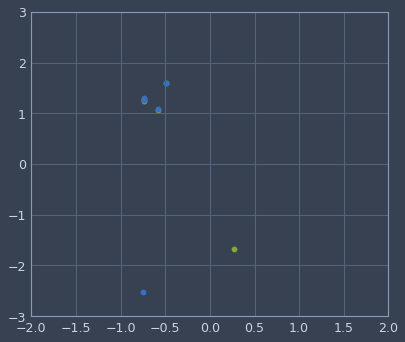

In [68]:
mask = g.final
plt.scatter(pmu1.eta,pmu1.phi, c='g')
plt.scatter(pmu2.eta,pmu2.phi+0.01, c='b')
plt.xlim(-2, 2)
plt.ylim(-3,3)

In [67]:
pmu1 = g.pmu[mask][[1,2,3,4,5,0]]
pmu2 = g.pmu[mask][[1,2,3,4,5,11]]

In [69]:
m3 = gcl.matrix.delta_R_aff(pmu1, pmu2)

In [71]:
M = ot.partial.partial_wasserstein(pmu1.data['e'], pmu2.data['e'], m3, 
                                   min(pmu1.data['e'].sum(), pmu2.data['e'].sum()))

In [72]:
np.sum(M * m3)

3.5112076634340355

In [73]:
min(pmu1.data['e'][-1], pmu2.data['e'][-1]) * m3[-1][-1]

3.511207663434391

In [89]:
hyp_record = [[],[],[]]
euc_record = [[],[],[]]

indices = [[1,2,3,4], [1,2,5,6], [3,4,5,6]]
for ev in tqdm(range(250)):
    data = dataset[ev]
    for idx, idx_list in enumerate(indices):
        a1, a2, a3, a4 = idx_list

        g1, h1 = data[keys[a1]], data[keys[a2]]
        g2, h2 = data[keys[a3]], data[keys[a4]]
        mask1 = g1.final
        mask2 = g2.final
        e1 = g1.pmu.data['e'][mask1]
        e2 = g2.pmu.data['e'][mask2]

        m = hyp_distance_matrix(h1[mask1],h2[mask2])
        #m = hyp_distance_matrix(h1,h2)
        M = ot.partial.partial_wasserstein(e1, e2, m, min(e1.sum(), e2.sum()))
        cost = np.sum(M * m)
        hyp_record[idx].append(cost)
        
        m = euc_distance_matrix(g1.pmu[mask1],g2.pmu[mask2])
        M = ot.partial.partial_wasserstein(e2, e1, m, min(e1.sum(), e2.sum()))
        cost = np.sum(M * m)
        euc_record[idx].append(cost)
    
hyp_record = np.array(hyp_record)
euc_record = np.array(euc_record)

100%|████████████████████████████████████| 250/250 [02:22<00:00,  1.76it/s]


In [137]:
mean = np.mean(record, axis=1)
print(f'EMD aKT to CA: {mean[0]:.2f}')
print(f'EMD aKT to Kt: {mean[1]:.2f}')
print(f'EMD Kt to aKt: {mean[2]:.2f}')

EMD aKT to CA: 80624.42
EMD aKT to Kt: 213981.41
EMD Kt to aKt: 196006.80


Hyperbolic space
mean aKt-CA: 6.2289
aKt-Kt: 12.1207
Kt-CA: 12.0343
Eta-Phi space
mean aKt-CA: 0.2859
aKt-Kt: 0.3175
Kt-CA: 0.1421


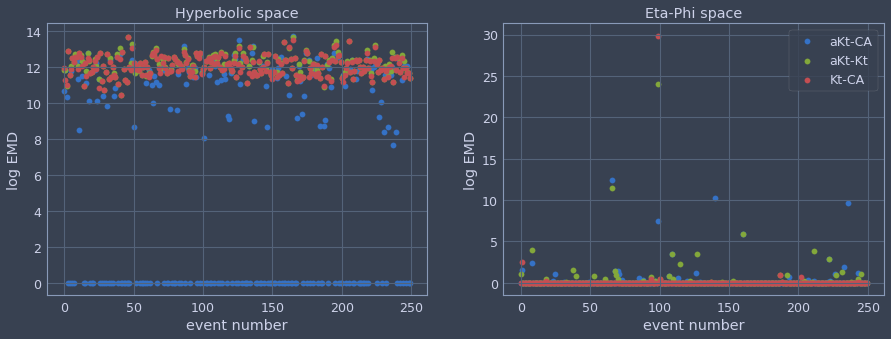

In [95]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
title = ['Hyperbolic space', 'Eta-Phi space']
for i in range(2):
    if i==0:
        record = np.log(hyp_record + 1)
    else:
        record = euc_record
    ax[i].scatter(range(len(record[0])), record[0], label='aKt-CA')
    ax[i].scatter(range(len(record[1])), record[1], label='aKt-Kt')
    ax[i].scatter(range(len(record[2])), record[2], label='Kt-CA')
    ax[i].set_xlabel('event number')
    ax[i].set_ylabel('log EMD')
    ax[i].set_title(title[i])
    
    print(title[i])
    print(f'mean aKt-CA: {np.mean(record[0]):.4f}')
    print(f'aKt-Kt: {np.mean(record[1]):.4f}')
    print(f'Kt-CA: {np.mean(record[2]):.4f}')
plt.legend()
plt.show()

Hyperbolic space
mean aKt-CA / aKt-Kt: 5.9339
aKt-CA / Kt-CA: 5.9331
aKt-Kt / Kt-CA: 0.0966
Eta-Phi space
mean aKt-CA / aKt-Kt: 0.3028
aKt-CA / Kt-CA: 0.3555
aKt-Kt / Kt-CA: 0.2487


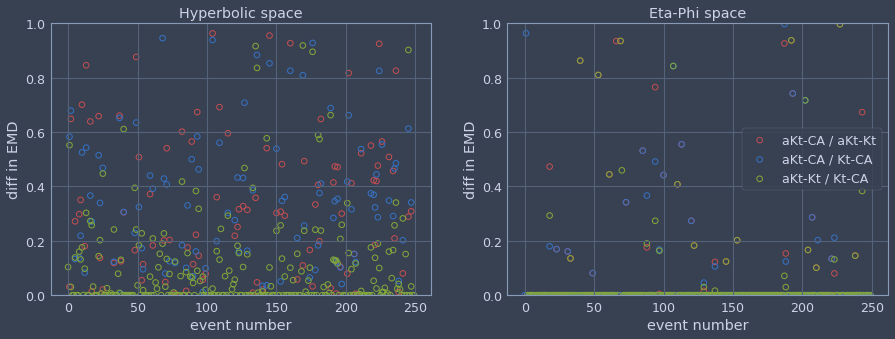

In [91]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
title = ['Hyperbolic space', 'Eta-Phi space']
for i in range(2):
    if i==0:
        record = np.log(hyp_record + 1)
    else:
        record = euc_record + 1e-5
    ax[i].scatter(range(len(record[0])), np.abs(record[0] - record[1]), 
                  label='aKt-CA / aKt-Kt',facecolor='none',edgecolor='r',linewidth=1)
    ax[i].scatter(range(len(record[1])), np.abs(record[0] - record[2]), 
                  label='aKt-CA / Kt-CA',facecolor='none',edgecolor='b',linewidth=1)
    ax[i].scatter(range(len(record[2])), np.abs(record[1] - record[2]), 
                  label='aKt-Kt / Kt-CA',facecolor='none',edgecolor='g',linewidth=1)
    ax[i].set_xlabel('event number')
    ax[i].set_ylabel('diff in EMD')
    ax[i].set_title(title[i])
    ax[i].set_ylim(0,1)
    
    print(title[i])
    print(f'mean aKt-CA / aKt-Kt: {np.mean(np.abs(record[0] - record[1])):.4f}')
    print(f'aKt-CA / Kt-CA: {np.mean(np.abs(record[0] - record[2])):.4f}')
    print(f'aKt-Kt / Kt-CA: {np.mean(np.abs(record[1] - record[2])):.4f}')
plt.legend()
plt.show()

/tmp/ipykernel_1822/1362750772.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


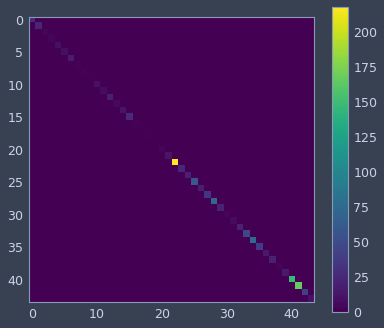

In [111]:
plt.imshow(M)
plt.grid(False)
plt.colorbar()

/tmp/ipykernel_1822/4068010689.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


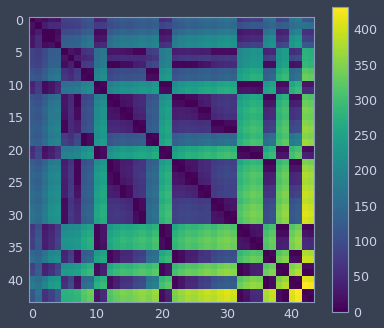

In [112]:
plt.imshow(m)
plt.grid(False)
plt.colorbar()